In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
concrete = pd.read_csv('data/concrete.csv')
co2 = pd.read_csv('data/co2.csv')

concrete['co2_lower'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'lower_bound'].values[0] for col in concrete.columns[:7]])
concrete['co2_upper'] = sum([concrete[col] * co2.loc[co2.ingredient == col, 'upper_bound'].values[0] for col in concrete.columns[:7]])

concrete = concrete[concrete['age'] < 120]

concrete_as = concrete[(concrete['ash'] > 0) & (concrete['slag'] > 0)]
concrete_a = concrete[(concrete['ash'] > 0) & (concrete['slag'] == 0)]
concrete_s = concrete[(concrete['ash'] == 0) & (concrete['slag'] > 0)]
concrete_ = concrete[(concrete['ash'] == 0) & (concrete['slag'] == 0)]

concrete_train, concrete_test = train_test_split(concrete,
                                                 shuffle=True,
                                                 random_state=487)

features = concrete.columns[:-3]

In [78]:
from xgboost import XGBRegressor

In [4]:
reg_for = RandomForestRegressor(n_estimators=300, max_depth=15)

reg_for.fit(concrete_train[features],concrete_train['strength'])

RandomForestRegressor(max_depth=15, n_estimators=300)

In [79]:
best_params = {'max_depth': 2, 'n_estimators': 1200, 'tree_method': 'approx'}
best_model = XGBRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], tree_method=best_params['tree_method'])
best_model.fit(concrete_train[features], concrete_train['strength'])
concrete_train['predict'] = best_model.predict(concrete_train[features])
concrete_test['predict'] = best_model.predict(concrete_test[features])

In [58]:
def co2_from_data(the_data):
    co22 = pd.read_csv('data/co2.csv')
    return sum([the_data[col] * co22.loc[co22.ingredient == col, 'lower_bound'].values[0] for col in the_data.columns[:7]])

def co2_from_data2(the_data):
    co22 = pd.read_csv('data/co2.csv')
    return sum(the_data[i]*co22['upper_bound'].loc[i] for i in range(7))

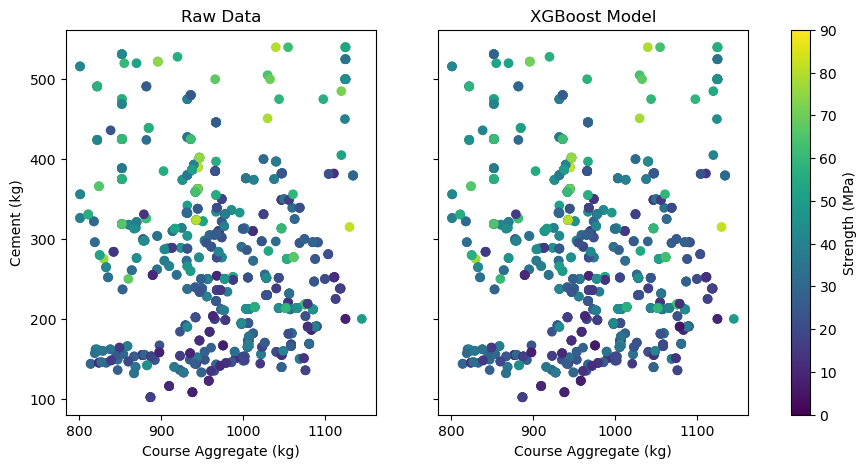

In [80]:
fig, ax = plt.subplots(1,2,sharey=True)
ax[0].scatter(concrete['coarseagg'],concrete['cement'],c=concrete['strength'],vmin=0,vmax=90)
ax[0].set_ylabel('Cement (kg)')
ax[0].set_title('Raw Data')
ax[0].set_xlabel('Course Aggregate (kg)')
here = ax[1].scatter(concrete['coarseagg'],concrete['cement'],c=best_model.predict(concrete[features]),vmin=0,vmax=90)
fig.colorbar(here,ax=ax,label='Strength (MPa)')
ax[1].set_title('XGBoost Model')
ax[1].set_xlabel('Course Aggregate (kg)')
fig.set_size_inches(11,5)
#fig.tight_layout()
plt.show()

In [83]:
water_density = 997 
cement_density = 2400
fine_density = 1602 
course_density = 1750 

par_slag = 0
par_ash = 0
par_water = 220
par_super = 0

par_fine = 800
par_age = 120

xnum = 50
ynum = 100
course_grid = np.linspace(800,1200,num=xnum)
cement_grid = np.linspace(100,600,num=ynum)
strength_grid = np.zeros((ynum,xnum))
co2_grid = np.zeros((ynum,xnum))
for i in range(xnum):
    for j in range(ynum):
        fake_panda = pd.DataFrame([[cement_grid[j],par_slag,par_ash,water_density*(1 - cement_grid[j]/cement_density - course_grid[i]/course_density - par_fine/fine_density),par_super,course_grid[i],par_fine,par_age]],columns=features)
        strength_grid[j,i] = best_model.predict(fake_panda)
        co2_grid[j,i] = co2_from_data(fake_panda)

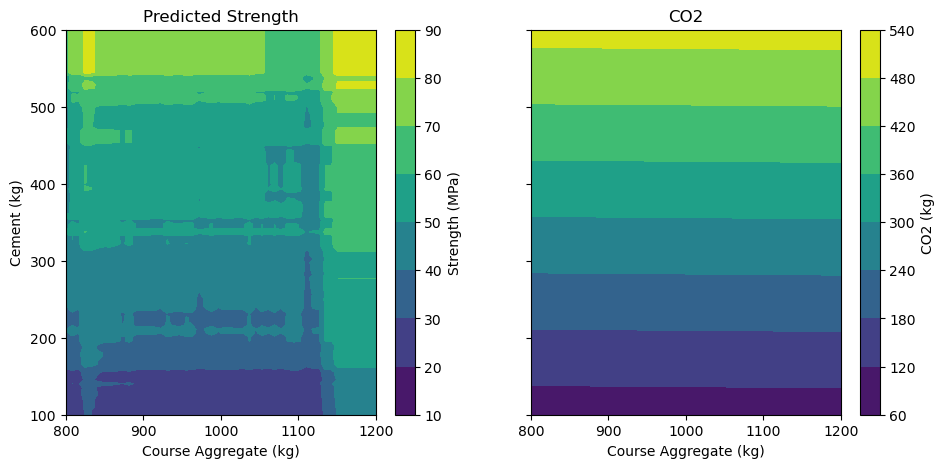

In [84]:
fig, ax = plt.subplots(1,2,sharey=True)
here0 = ax[0].contourf(course_grid,cement_grid,strength_grid)
ax[0].set_ylabel('Cement (kg)')
ax[0].set_title('Predicted Strength')
ax[0].set_xlabel('Course Aggregate (kg)')
plt.colorbar(here0,ax=ax[0],label='Strength (MPa)')
here1 = ax[1].contourf(course_grid,cement_grid,co2_grid)
plt.colorbar(here1,ax=ax[1],label='CO2 (kg)')
ax[1].set_title('CO2')
ax[1].set_xlabel('Course Aggregate (kg)')
fig.set_size_inches(11,5)
#fig.tight_layout()
plt.show()

In [62]:
concrete[(concrete['ash'] == 0) & (concrete['slag'] == 0)].describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength,co2_lower,co2_upper
count,198.000000,198.0,198.0,198.00000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000
mean,365.500505,0.0,0.0,187.79798,1.276263,1013.012626,777.627778,27.404040,30.250354,307.994874,356.760974
std,91.900039,0.0,0.0,14.59157,4.763652,79.332787,77.510000,27.502439,15.924017,75.188865,76.541345
min,200.000000,0.0,0.0,140.00000,0.000000,801.000000,594.000000,1.000000,6.270000,173.132500,224.009000
25%,296.250000,0.0,0.0,185.00000,0.000000,966.500000,745.000000,7.000000,17.550000,251.552625,301.191800
50%,349.000000,0.0,0.0,191.00000,0.000000,1012.500000,784.000000,28.000000,26.895000,294.734400,341.344900
75%,399.250000,0.0,0.0,192.00000,0.000000,1085.000000,822.150000,28.000000,39.240000,335.666661,384.010952
max,540.000000,0.0,0.0,228.00000,28.200000,1125.000000,945.000000,100.000000,79.990000,451.350750,508.773440
